
## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [1]:
'''
# for augmentations
!pip install albumentations

# for pretrained segmentation models fo PyTorch
!pip install segmentation-models-pytorch

# for TTA
!pip install ttach

################
# Catalyst itself
!pip install -U catalyst
# For specific version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
################

# for tensorboard
!pip install tensorflow
%load_ext tensorboard


# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True
'''

'\n# for augmentations\n!pip install albumentations\n\n# for pretrained segmentation models fo PyTorch\n!pip install segmentation-models-pytorch\n\n# for TTA\n!pip install ttach\n\n################\n# Catalyst itself\n!pip install -U catalyst\n# For specific version of catalyst, uncomment:\n# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}\n################\n\n# for tensorboard\n!pip install tensorflow\n%load_ext tensorboard\n\n\n# if Your machine support Apex FP16, uncomment this 3 lines below\n# !git clone https://github.com/NVIDIA/apex\n# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex\n# is_fp16_used = True\n'

### Colab extras – Plotly

To intergate visualization library `plotly` to colab, run

## Setting up GPUs

In [2]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst.contrib.models.segmentation import Unet

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.3.1, catalyst: 19.12.2


In [3]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

-------

## Dataset

As a dataset we will take Carvana - binary segmentation for the "car" class.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [4]:
#%%bash

#download-gdrive 1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj segmentation_data.zip
#extract-archive segmentation_data.zip &>/dev/null

In [5]:
from pathlib import Path

ROOT = Path("data/carvana_data/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"
test_image_path = ROOT / "test"

In [6]:
train_image_path

PosixPath('data/carvana_data/train')

Collect images and masks into variables.

In [7]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

5088

In [8]:
ALL_MASKS = sorted(train_mask_path.glob("*.gif"))
len(ALL_MASKS)

5088

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(str(image_path))
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

You can restart the cell below to see more examples.

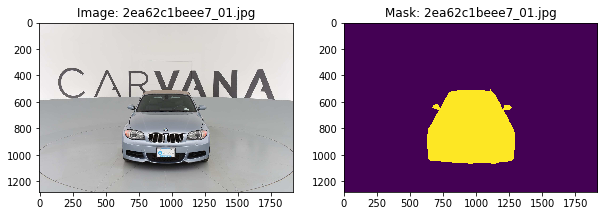

In [10]:
show_random(ALL_IMAGES, ALL_MASKS)

The dataset below reads images and masks and optionally applies augmentation to them.

In [11]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

-------

### Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [12]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [13]:
train_transforms = compose([
    resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

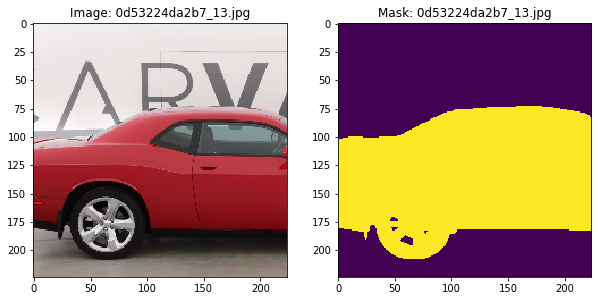

In [14]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

-------

## Loaders

In [15]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [16]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 32


-------

## Experiment
### Model

Catalyst has [several segmentation models](https://github.com/catalyst-team/catalyst/blob/master/catalyst/contrib/models/segmentation/__init__.py#L16) (Unet, Linknet, FPN, PSPnet and their versions with pretrain from Resnet).

> You can read more about them in [our blog post](https://github.com/catalyst-team/catalyst-info#catalyst-info-1-segmentation-models).

But for now let's take the model from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) (SMP for short). The same segmentation architectures have been implemented in this repository, but there are many more pre-trained encoders.

[![Segmentation Models logo](https://raw.githubusercontent.com/qubvel/segmentation_models.pytorch/master/pics/logo-small-w300.png)](https://github.com/qubvel/segmentation_models.pytorch)

### Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.


### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [17]:
%load_ext tensorboard
%tensorboard --logdir {logdir}

Reusing TensorBoard on port 6007 (pid 14346), started 0:00:51 ago. (Use '!kill 14346' to kill it.)

In [18]:
import torch
import torch.nn as nn
from catalyst.dl.runner import SupervisedRunner

# experiment setup
num_epochs = 50
logdir = "./logs/segmentation_notebook"

# model, criterion, optimizer
model = Unet(num_classes=6, in_channels=1, num_channels=64, num_blocks=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/50 * Epoch (train):   0% 0/127 [00:00<?, ?it/s]

KeyError: 'features'

### Running train-loop

### Training analysis

The `utils.plot_metrics` method reads tensorboard logs from the logdir and plots beautiful metrics with `plotly` package.

In [ ]:
# tensorboard should be enought, uncomment to check plotly version
# it can take a while (colab issue)
# utils.plot_metrics(
#     logdir=logdir, 
#     # specify which metrics we want to plot
#     metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
# )

## Model inference

Let's look at model predictions.


In [ ]:
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

# create test dataset
test_dataset = SegmentationDataset(
    TEST_IMAGES, 
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = runner.predict_loader(
    model=model,
    loader=infer_loader,
    resume=f"{logdir}/checkpoints/best.pth",
    verbose=False,
)

print(type(predictions))
print(predictions.shape)

In [ ]:
threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")
        
    show_examples(name="", image=image, mask=mask)
    
    if i >= max_count:
        break

## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

After this, you can easily load the model and predict anything!

In [ ]:
if is_fp16_used:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward-opt_O1.pth", device="cuda", opt_level="O1")
else:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward.pth", device="cpu")

In [ ]:
model_input = batch["image"].to("cuda" if is_fp16_used else "cpu")
model(model_input)

### Advanced: Custom Callbacks

Let's plot the heatmap of predicted masks.

In [ ]:
import collections

from catalyst.dl import Callback, CallbackOrder, RunnerState


class CustomInferCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Internal)
        self.heatmap = None
        self.counter = 0

    def on_loader_start(self, state: RunnerState):
        self.predictions = None
        self.counter = 0

    def on_batch_end(self, state: RunnerState):
        # data from the Dataloader
        # image, mask = state.input["image"], state.input["mask"]
        logits = state.output["logits"]
        probabilities = torch.sigmoid(logits)

        self.heatmap = (
            probabilities 
            if self.heatmap is None 
            else self.heatmap + probabilities
        )
        self.counter += len(probabilities)

    def on_loader_end(self, state: RunnerState):
        self.heatmap = self.heatmap.sum(axis=0)
        self.heatmap /= self.counter

In [ ]:
from collections import OrderedDict
from catalyst.dl.callbacks import CheckpointCallback


infer_loaders = {"infer": loaders["valid"]}
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1, dropout=0.05)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

In [ ]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

heatmap = utils.detach(runner.callbacks["infer"].heatmap[0])
plt.figure(figsize=(20, 9))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.show()

### Advanced: test-time augmentations (TTA)

There is [ttach](https://github.com/qubvel/ttach) is a new awesome library for test-time augmentation for segmentation or classification tasks.

In [ ]:
import ttach as tta

# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    device=utils.get_device(),
    input_key="image"
)

In [ ]:
infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

Let's see our mask after TTA

In [ ]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)